#Python Code

In [2]:
import kagglehub

path = kagglehub.dataset_download("dhruvildave/new-york-city-taxi-trips-2019")

print("Path to dataset files:", path)

C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.38G/2.38G [01:11<00:00, 35.7MB/s]

Extracting files...


Path to dataset files: C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4


In [4]:
import os
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['2019', 'data_dictionary.pdf', 'taxi_zones', 'taxi_zone_lookup.csv']


In [5]:
dataset_path = path

year_2019_path = os.path.join(dataset_path, "2019")
if os.path.exists(year_2019_path):
    print("Files in 2019 folder:", os.listdir(year_2019_path))

taxi_zones_path = os.path.join(dataset_path, "taxi_zones")
if os.path.exists(taxi_zones_path):
    print("Files in taxi_zones folder:", os.listdir(taxi_zones_path))

Files in 2019 folder: ['2019-01.sqlite', '2019-02.sqlite', '2019-03.sqlite', '2019-04.sqlite', '2019-05.sqlite', '2019-06.sqlite', '2019-07.sqlite', '2019-08.sqlite', '2019-09.sqlite', '2019-10.sqlite', '2019-11.sqlite', '2019-12.sqlite']
Files in taxi_zones folder: ['taxi_zones.dbf', 'taxi_zones.prj', 'taxi_zones.sbn', 'taxi_zones.sbx', 'taxi_zones.shp', 'taxi_zones.shp.xml', 'taxi_zones.shx']


In [6]:
import sqlite3
import pandas as pd
import os

output_csv = "nyc_taxi_2019_combined.csv"

sqlite_files = [os.path.join(path, "2019", f) for f in os.listdir(os.path.join(path, "2019")) if f.endswith(".sqlite")]

first_file = sqlite_files[0]
conn = sqlite3.connect(first_file)
df_temp = pd.read_sql("SELECT * FROM tripdata LIMIT 1000;", conn) 
conn.close()
df_temp.to_csv(output_csv, index=False)  

for file in sqlite_files:
    print(f"Processing {file}...")
    conn = sqlite3.connect(file)

    chunk_size = 500000 
    for chunk in pd.read_sql("SELECT * FROM tripdata;", conn, chunksize=chunk_size):
        chunk.to_csv(output_csv, mode='a', header=False, index=False)

    conn.close()
    print(f"Finished {file}")

print("All data saved to CSV without crashing!")

Processing C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-01.sqlite...
Finished C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-01.sqlite
Processing C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-02.sqlite...
Finished C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-02.sqlite
Processing C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-03.sqlite...
Finished C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-03.sqlite
Processing C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-04.sqlite...
Finished C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-04.sql

In [2]:
import pandas as pd

df = pd.read_csv("nyc_taxi_2019_combined.csv", nrows=10000, low_memory=False)

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

df = df[(df['trip_distance'] > 0) & (df['fare_amount'] > 0)]

print(df.info())
print(df.head())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 9923 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   vendorid               9923 non-null   float64       
 1   tpep_pickup_datetime   9923 non-null   datetime64[ns]
 2   tpep_dropoff_datetime  9923 non-null   datetime64[ns]
 3   passenger_count        9923 non-null   float64       
 4   trip_distance          9923 non-null   float64       
 5   ratecodeid             9923 non-null   float64       
 6   store_and_fwd_flag     9923 non-null   object        
 7   pulocationid           9923 non-null   float64       
 8   dolocationid           9923 non-null   float64       
 9   payment_type           9923 non-null   float64       
 10  fare_amount            9923 non-null   float64       
 11  extra                  9923 non-null   float64       
 12  mta_tax                9923 non-null   float64       
 13  tip_amou

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['trip_distance', 'fare_amount', 'total_amount', 'tolls_amount']] = scaler.fit_transform(df[['trip_distance', 'fare_amount', 'total_amount', 'tolls_amount']])

df['payment_type'] = df['payment_type'].astype(int)
df['vendorid'] = df['vendorid'].astype(int)
df['ratecodeid'] = df['ratecodeid'].astype(int)

Q1 = df[['fare_amount', 'trip_distance']].quantile(0.25)
Q3 = df[['fare_amount', 'trip_distance']].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[['fare_amount', 'trip_distance']] < (Q1 - 1.5 * IQR)) | (df[['fare_amount', 'trip_distance']] > (Q3 + 1.5 * IQR))).any(axis=1)]

print("Data Cleaning Complete!")

Data Cleaning Complete!


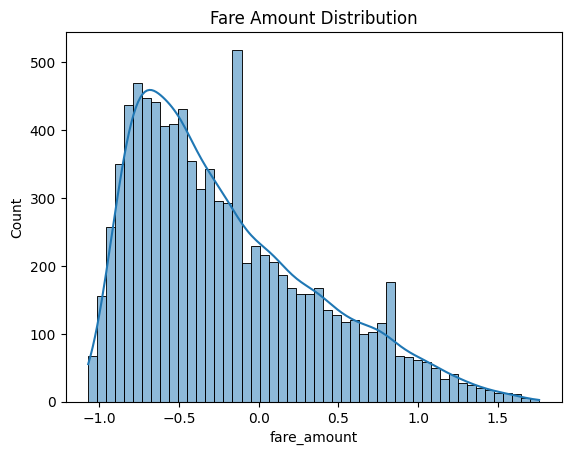

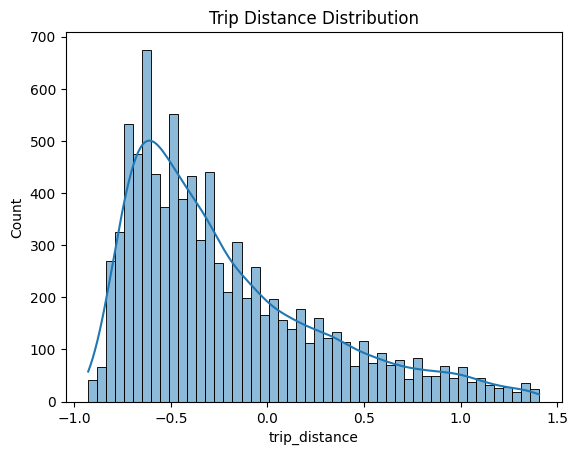

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Histogram of fares
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title("Fare Amount Distribution")
plt.show()

# Histogram of trip distances
sns.histplot(df['trip_distance'], bins=50, kde=True)
plt.title("Trip Distance Distribution")
plt.show()

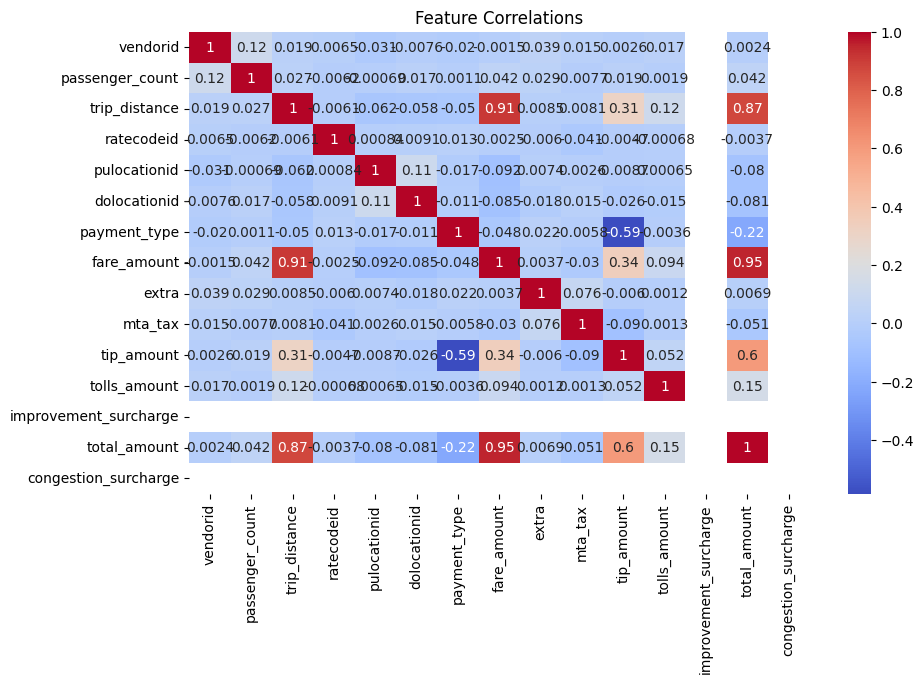

In [5]:
df_numeric = df.select_dtypes(include=[np.number])

corr_matrix = df_numeric.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()